When benchmarking you **MUST**

1. close all applications
2. close docker
3. close all but this Web windows
4. all pen editors other than jupyter-lab (this notebook)


In [1]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
from tqdm.notebook import tqdm
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.StopWatch import StopWatch 
from cloudmesh.common.systeminfo import systeminfo
import ipywidgets as widgets

sns.set_theme(style="whitegrid")
info = systeminfo()

/home/green/ENV3/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:

user = info["user"] 
node = info["uname.node"]
processors = 4

In [3]:
# Parameters
user = "gregor"
node = "alienware"
processors = 25


In [4]:
p = widgets.IntSlider(
    value=processors,
    min=1,
    max=64,
    step=1,
    description='Processors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
u = widgets.Text(value=user, placeholder='The user name', description='User:', disabled=False)
n = widgets.Text(value=node, placeholder='The computer name', description='Computer:', disabled=False)

display(p)
display(u)
display(n)

IntSlider(value=25, continuous_update=False, description='Processors:', max=64, min=1)

Text(value='gregor', description='User:', placeholder='The user name')

Text(value='alienware', description='Computer:', placeholder='The computer name')

In [5]:
processors = p.value
user = u.value
node = n.value
print (processors, user, node)

25 gregor alienware


In [6]:

experiments = 10
maximum = 1024 * 100000
intervals = 10

In [7]:
label = f"{user}-{node}-{processors}"
output = f"benchmark/{user}"

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)

[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[2, 409600, 819200, 1228800, 1638400, 2048000, 2457600, 2867200, 3276800, 3686400]


In [8]:
os.makedirs(output, exist_ok=True)

In [9]:
systeminfo = StopWatch.systeminfo({"user": user, "uname.node": node})
writefile(f"{output}/{label}-sysinfo.log", systeminfo)
print (systeminfo)

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | hirsute                                                          |
| DISTRIB_DESCRIPTION | "Ubuntu 21.04"                                                   |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 21.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           |

In [10]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [11]:


experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    log = f"{output}/{label}-{experiment}-log.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        #if linux, os:
        command = f"mpiexec -n {processors} python count-click.py " + \
                  f"--n {n} --max_number 10 --find 8 --label {label} " + \
                  f"--user {user} --node={node} " + \
                  f"| tee -a {log}"
        #if windows: 
        #command = f"mpiexec -n {processors} python count-click.py " + \
        #          f"--n {n} --max_number 10 --find 8 --label {label} " + \
        #          f"--user {user} --node={node} " + \
        #          f">> {log}"
        
        os.system (command)

    content = readfile(log).splitlines()
    lines = Shell.cm_grep(content, "csv,Result:")
    # print(lines)
    values = []
    times = []

    for line in lines:
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 2                    10 | 0/10 [00:00<?, ?it/s]

Benchmark 409600               10 | 0/10 [00:00<?, ?it/s]

Benchmark 819200               10 | 0/10 [00:00<?, ?it/s]

Benchmark 1228800              10 | 0/10 [00:00<?, ?it/s]

Benchmark 1638400              10 | 0/10 [00:00<?, ?it/s]

Benchmark 2048000              10 | 0/10 [00:00<?, ?it/s]

Benchmark 2457600              10 | 0/10 [00:00<?, ?it/s]

Benchmark 2867200              10 | 0/10 [00:00<?, ?it/s]

Benchmark 3276800              10 | 0/10 [00:00<?, ?it/s]

Benchmark 3686400              10 | 0/10 [00:00<?, ?it/s]

In [12]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
2,0.008,0.002,0.105,0.101,0.001,0.001,0.035,0.005,0.071,0.001
409600,0.641,0.659,0.620,0.587,0.673,0.680,0.570,0.571,0.680,0.567
819200,1.160,1.170,1.150,1.147,1.132,1.118,1.139,1.138,1.139,1.581
1228800,1.698,2.444,1.745,1.795,1.705,1.717,1.737,1.691,1.728,1.696
1638400,2.310,2.257,3.232,2.278,2.371,2.269,2.259,2.285,2.252,2.317
2048000,2.815,2.899,2.887,2.868,2.827,2.887,2.851,2.957,2.832,2.815
2457600,3.584,3.383,3.366,3.444,3.480,3.451,3.410,3.456,3.543,3.516
2867200,3.966,3.967,4.121,4.074,4.160,4.157,4.238,3.970,3.970,3.954
3276800,4.646,4.546,4.515,4.632,4.542,4.493,4.632,4.549,4.527,4.654


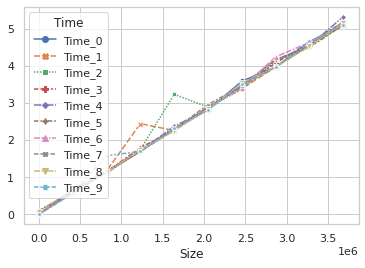

In [13]:
sns.lineplot(data=df, markers=True);

In [14]:
plt.savefig(f'{output}/{label}-line.png');
plt.savefig(f'{output}/{label}-line.pdf');

<Figure size 432x288 with 0 Axes>

In [15]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
2,0.008
2,0.002
2,0.105
2,0.101
2,0.001
...,...
3686400,5.098
3686400,5.110
3686400,5.181


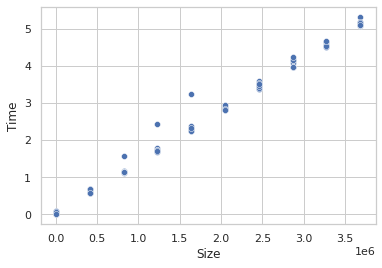

In [16]:
sns.scatterplot(data=dfs, x="Size", y="Time");
plt.savefig(f"{output}/{label}-scatter.pdf")
plt.savefig(f"{output}/{label}-scatter.png")

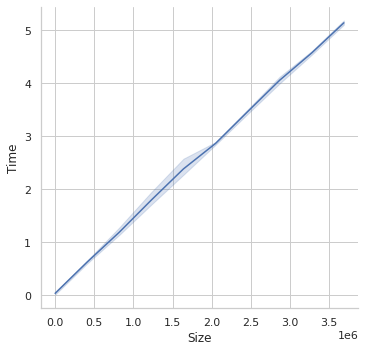

In [17]:
sns.relplot(x="Size", y="Time", kind="line", data=dfs);
plt.savefig(f"{output}/{label}-relplot.pdf")
plt.savefig(f"{output}/{label}-relplot.png")

In [18]:
df.to_pickle(f"{output}/{label}-df.pkl")